# WasmTreeDataset performances vs Graphy vs Sophia

More on the context
- https://github.com/BruJu/Portable-Reasoning-in-Web-Assembly
- https://github.com/BruJu/Portable-Reasoning-in-Web-Assembly/blob/master/notes/rustvsjs/CompareTarget.ipynb

We benchmark using the sophia_benchmark infrastructure the speed of retrieval of the second request for given S / SP / PO / POG on the PersonData database.

## Loading data

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [6]:
datasets = [
    ("Sophia Fast", ["sophia", "sophia_js", None]),
    ("Sophia Tree", ["sophia_tree", "sophia_js_tree", None]),
    ("Graphy", [None, "sophia_js_graphy", None]),
    ("Web Tree", [None, "rust_wrapped", "store_wasm"]),
    ("Store n3", [None, None, "store_n3"]),
]

prefixes = "data/wrappedbench_" # This name is so stupid
queries = ["query", "query3", "query2", "query4"]
extension = ".csv"

def query_test(query):
    if query == "query" or query == "query1":
        return "<POG>"
    elif query == "query2":
        return "<SG>"
    elif query == "query3":
        return "<PO>"
    else:
        return "<S>"

## Compute average

In [12]:
data = {}

for query in queries:
    for dataset_kind in datasets:
        name = dataset_kind[0]
        list_of_files = dataset_kind[1]

        def read_file(filename, prefix):
            d = {}
            
            if filename is None:
                return d
            
            filename = prefix + query + "-" + filename + extension

            with open(filename, 'r') as file:
                reader = csv.reader(file)

                is_first = True
                for row in reader:
                    if is_first:
                        is_first = False
                    else:
                        nb_of_quads = int(row[1])
                        if nb_of_quads not in d:
                            d[nb_of_quads] = []

                        total_time = float(row[7]) + float(row[8])
                        #total_time = float(row[2]) + max(float(row[5]) + float(row[6]), float(row[7]) + float(row[8]))
                        #total_time = float(row[7])
                        d[nb_of_quads].append(total_time)
        
            return d

        data[("Rust", name, query)] = read_file(list_of_files[0], "data/wrappedbench_")
        data[("Wasm", name, query)] = read_file(list_of_files[1], "data/wrappedbench_")
        data[("Store", name, query)] = read_file(list_of_files[2], "data/results_")

def avg(l):
    i = 0
    for x in l:
        i += x
    return i / len(l)

for key in data:
    for ds in data[key]:
        data[key][ds] = avg(data[key][ds])

In [8]:
import pprint as pp

for x in data:
    print(x)
    pp.pprint(data[x], indent=2)
    break

('Rust', 'Sophia Fast', 'query')
{ 10000: 0.04240310175,
  20000: 0.0907514845,
  40000: 0.188169368,
  80000: 0.35111996324999994,
  100000: 0.47945984475,
  1000000: 4.94946308075}


In [13]:
def draw_plot(queries, graph_name, intermediates):
    if graph_name == "Web Tree":
        return

    plt.rcParams["figure.figsize"]=20,10
    
    def dd(query_name, p):
        for target in ['Rust', 'Wasm', "Store"]:
            x = []
            y = []

            for entry in data:
                if entry[0] == target and entry[1] == graph_name and entry[2] == query_name:
                    for size in data[entry]:
                        x.append(size)
                        y.append(data[entry][size])

            qname = query_name
            if qname == "query":
                qname = "query1"

            p.loglog(x, y, label=target)
        
        if graph_name == "Sophia Tree":
            for target in ['Wasm', "Store"]:
                x = []
                y = []

                for entry in data:
                    if entry[0] == target and entry[1] == "Web Tree" and entry[2] == query_name:
                        for size in data[entry]:
                            x.append(size)
                            y.append(data[entry][size])

                qname = query_name
                if qname == "query":
                    qname = "query1"

                p.loglog(x, y, label="Web" if target == 'Wasm' else 'Store')
        
        p.legend()
    
    fig, axs = plt.subplots(2, 2, sharex='col', sharey='row')
    (p1, p2), (p3, p4) = axs
    
    dd(queries[0], p1)
    dd(queries[1], p2)
    dd(queries[2], p3)
    dd(queries[3], p4)
    print("Comparing " + graph_name + " Dataset on POG / PO then SG / S")
    
    axes = plt.gca()
    axes.set_ylim([10**-7, 1])
    p1.set_ylim([10**-7, 1])
    p2.set_ylim([10**-7, 1])
    p3.set_ylim([10**-7, 1])
    p4.set_ylim([10**-7, 1])
    plt.show()

## Plot drawing

We draw a plot for every dataset and query to compare the plot shape

- x = number of quads in the dataset
- y = time to answer in second

When using the `match` function a new dataset is created. Self means that the same dataset structure is used to wrap the new dataset, Array means that the created dataset is a simple array.

Comparing Sophia Fast Dataset on POG / PO then SG / S


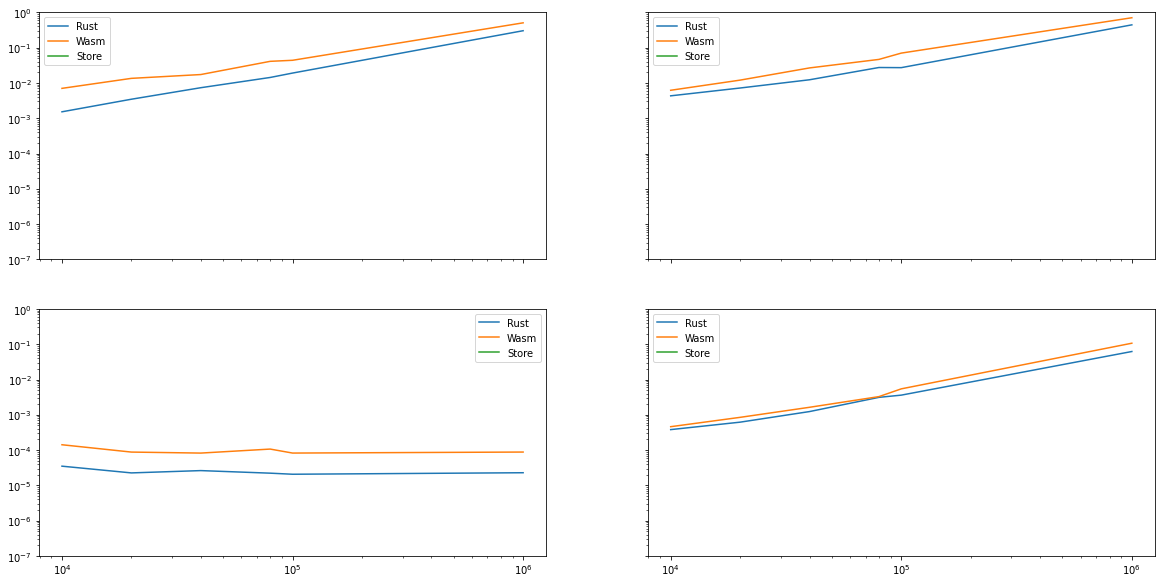

Comparing Sophia Tree Dataset on POG / PO then SG / S


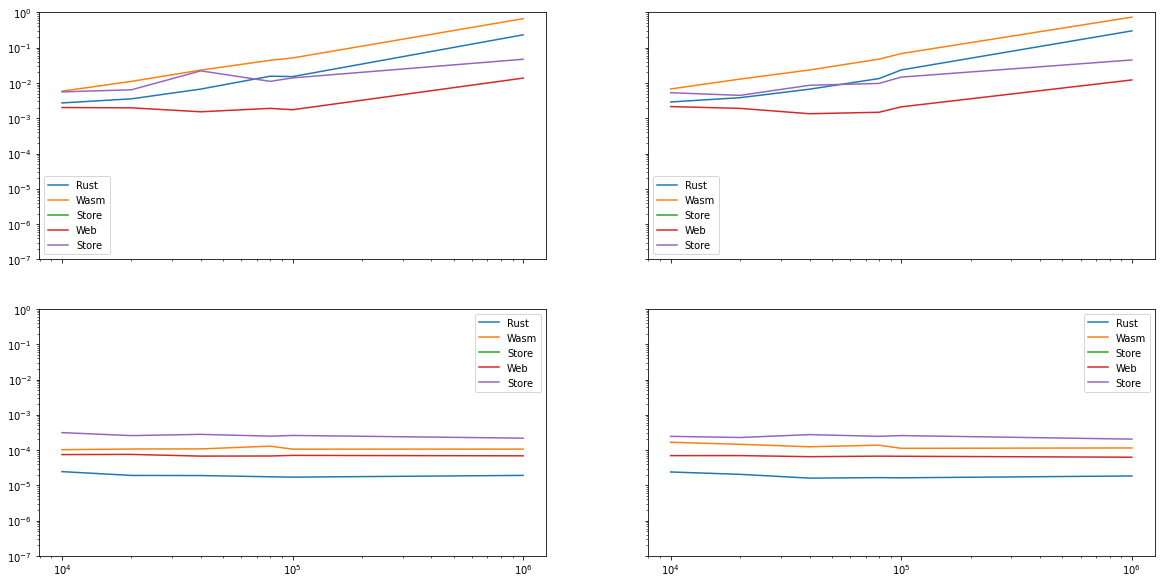

Comparing Graphy Dataset on POG / PO then SG / S


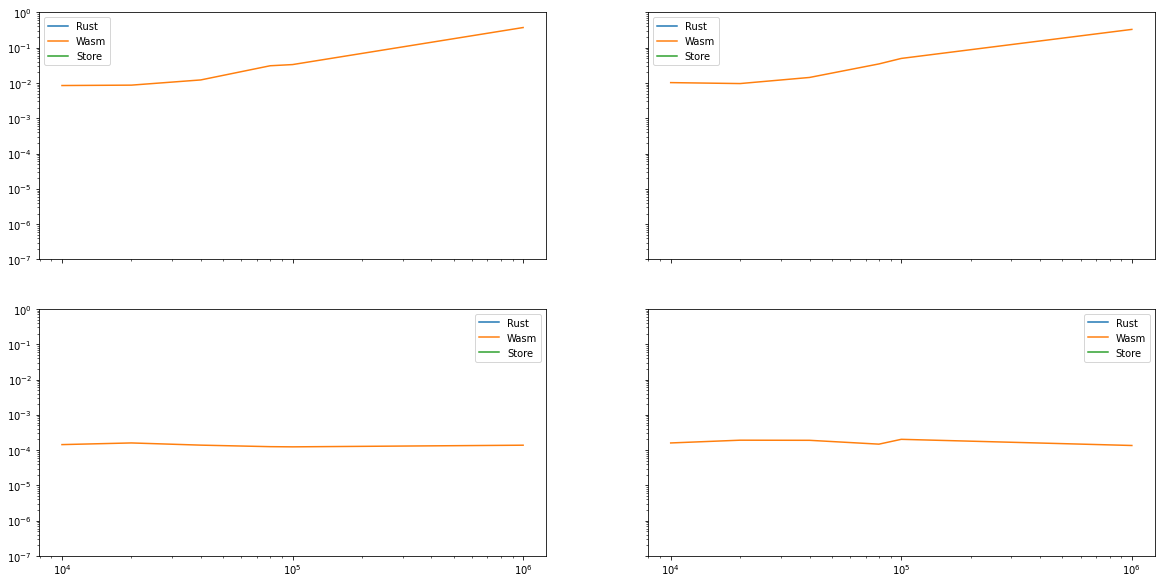

Comparing Store n3 Dataset on POG / PO then SG / S


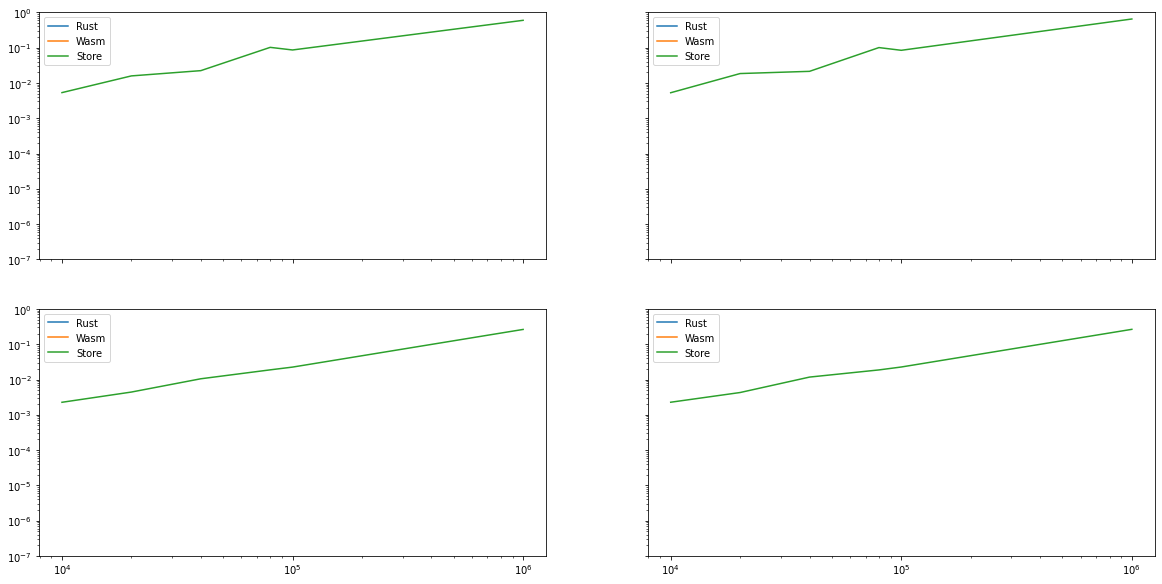

In [14]:
for dataset_type in datasets:
    draw_plot(["query", "query3", "query2", "query4"], dataset_type[0], ["Self", "Array"])

For the same query and datastructure, native Rust and Wasm exported datasets have the same plot, ie the same complexity.

## Comparing different datasets

A new draw plot function

In [15]:
def draw_plots(queries, datasets, targets):
    def make_title(q, d, t):
        if d == "Graphy":
            return "Graphy"
        
        #if d == "Web Tree":
        #    return "Web Tree"
        
        zz = ""
        
        if len(queries) != 1:
            zz += q + " "        
        if len(datasets) != 1:
            zz += d + " "        
        if len(targets) != 1:
            zz += t + " "
        
        return zz
    
    
    for query in queries:
        for target in targets:
            for dataset in datasets:
                x = []
                y = []

                for entry in data:
                    if entry[2] == query and entry[1] == dataset and target == entry[0]:
                        for size in data[entry]:
                            x.append(size)
                            y.append(data[entry][size])
                
                if len(x) > 0:
                    plt.loglog(x, y, label=make_title(query, dataset, target))
        
    # plt.title("Comparing " + graph_name + " Dataset on " + qname)
    axes = plt.gca()
    axes.set_ylim(10**-7, 1)
    plt.legend()
    
    plt.show()
    
plt.rcParams["figure.figsize"]=10,5

## Web tree performances

### In NodeJS

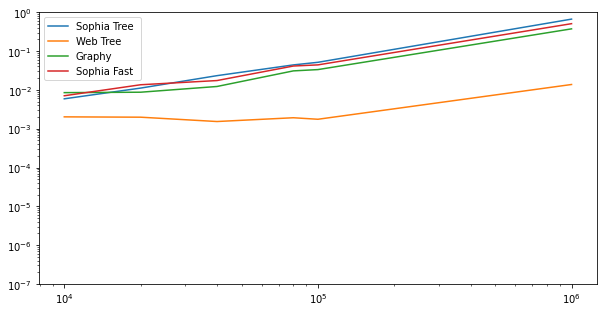

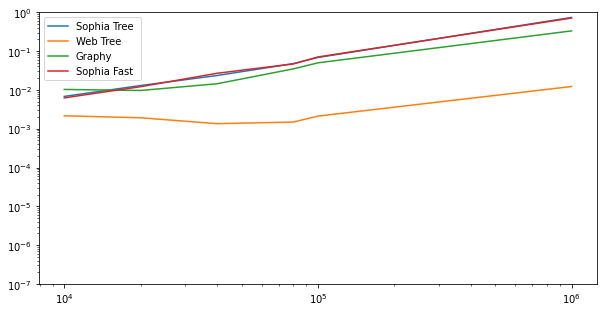

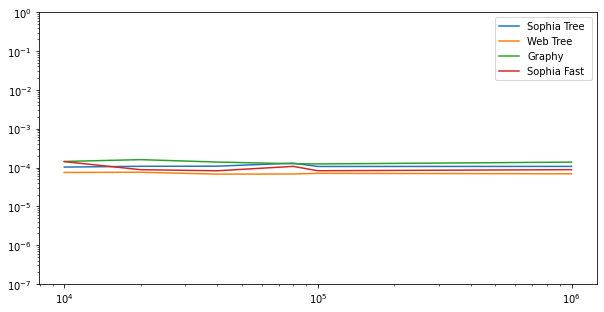

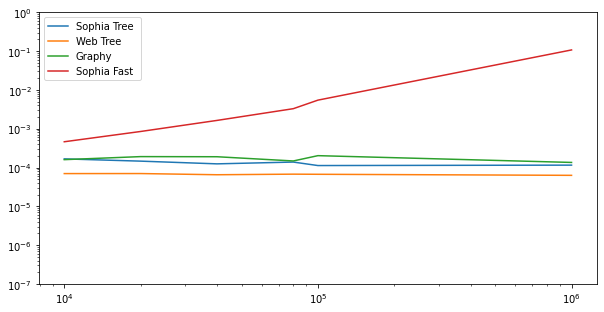

In [18]:
for q in queries:
    draw_plots([q], ["Sophia Tree", "Web Tree", "Graphy", "Sophia Fast"], ["Wasm"])

## vs Sophia

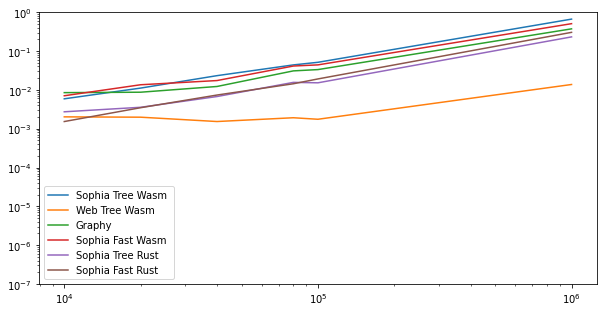

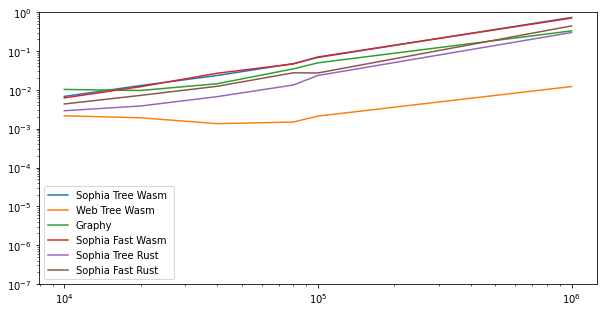

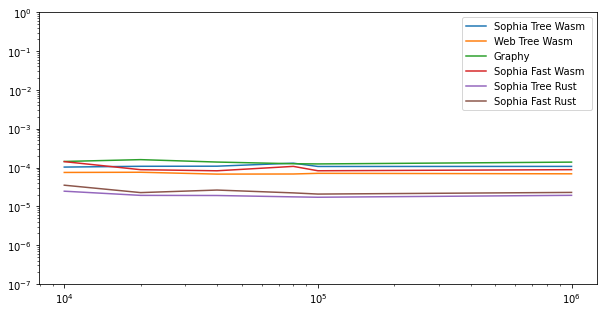

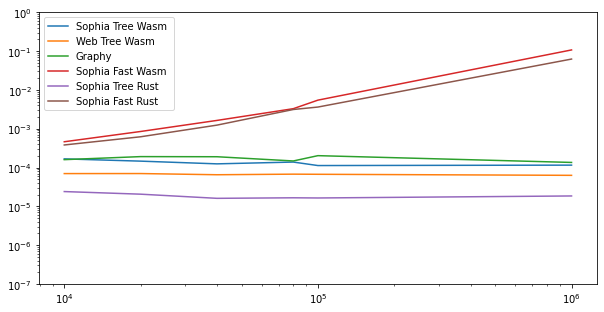

In [19]:
for q in queries:
    draw_plots([q], ["Sophia Tree", "Web Tree", "Graphy", "Sophia Fast"], ["Wasm", "Rust"])

~~Trees are awesome. Save the planet, plant trees~~

The concise method to store the indexmap and/or the lazyness of not being able to remove unused quad and/or the sharing of the indexmap let us be faster than native Sophia for big datasets.

## Speedup

In [20]:
def write_speedups(exported_dataset_of_interest=["Sophia Tree", "Sophia Fast"]):
    sizes = [10000, 1000000]

    times = {}

    for q in queries:
        for s in sizes:
            times[(q, s)] = [None for x in range(len(exported_dataset_of_interest) * 2 + 2)]

    for d in data:
        for s in data[d]:
            if s not in sizes:
                continue
            
            i = None

            if d[1] == "Web Tree":
                i = 0
            if d[1] == "Graphy":
                i = 1
            if d[1] in exported_dataset_of_interest:
                i = exported_dataset_of_interest.index(d[1]) + 2
                if d[0] == "Rust":
                    i += len(exported_dataset_of_interest)
            if i is None:
                continue
            
            times[(d[2], s)][i] = data[d][s]
    
    for cat in times:
        for i in range(1, len(times[cat])):
            times[cat][i] = times[cat][i] / times[cat][0]

    print("**Speedup of Web Tree against**")
    print()
    print("| Query | Size | Graphy "
        + "".join([" | JS " + x for x in exported_dataset_of_interest])
        + "".join([" | RS " + x for x in exported_dataset_of_interest])
        + " |"
        )
    print("| --- | --- | --- " + "".join([" | ---" for x in range(len(exported_dataset_of_interest) * 2)]) + " | ")

    for s in sizes:
        for q in queries:
            text = "| {} | {}".format(query_test(q)[1:-1], s)
            for i in range(1, len(times[(q, s)])):
                text += " | {:0.2%}".format(times[(q, s)][i])
            text += " | " 
            print(text)

write_speedups()

**Speedup of Web Tree against**

| Query | Size | Graphy  | JS Sophia Tree | JS Sophia Fast | RS Sophia Tree | RS Sophia Fast |
| --- | --- | ---  | --- | --- | --- | --- | 
| POG | 10000 | 151.11% | 104.74% | 125.62% | 48.53% | 27.23% | 
| PO | 10000 | 192.99% | 127.65% | 117.09% | 54.57% | 81.50% | 
| SG | 10000 | 45.76% | 32.80% | 45.34% | 7.85% | 11.20% | 
| S | 10000 | 64.93% | 67.95% | 187.60% | 9.78% | 155.02% | 
| POG | 1000000 | 792.05% | 1410.79% | 1076.55% | 491.77% | 643.66% | 
| PO | 1000000 | 734.13% | 1631.20% | 1570.03% | 666.19% | 987.25% | 
| SG | 1000000 | 63.24% | 49.05% | 40.44% | 8.83% | 10.49% | 
| S | 1000000 | 66.07% | 56.30% | 52170.82% | 9.05% | 30366.56% | 


**Speedup of Web Tree against**

| Query | Size | Graphy  | JS Sophia Tree | JS Sophia Fast | RS Sophia Tree | RS Sophia Fast |
| --- | --- | ---  | --- | --- | --- | --- | 
| POG | 10000 | 420.42% | 291.43% | 349.50% | 135.03% | 75.75% | 
| PO | 10000 | 477.62% | 315.93% | 289.79% | 135.07% | 201.70% | 
| SG | 10000 | 191.78% | 137.47% | 190.01% | 32.90% | 46.95% | 
| S | 10000 | 228.53% | 239.17% | 660.32% | 34.43% | 545.65% | 
| POG | 1000000 | 2710.51% | 4827.92% | 3684.12% | 1682.91% | 2202.71% | 
| PO | 1000000 | 2705.92% | 6012.44% | 5786.97% | 2455.49% | 3638.90% | 
| SG | 1000000 | 200.04% | 155.15% | 127.93% | 27.92% | 33.19% | 
| S | 1000000 | 214.91% | 183.11% | 169687.11% | 29.44% | 98768.12% |  | 

The higher the better

<POG>


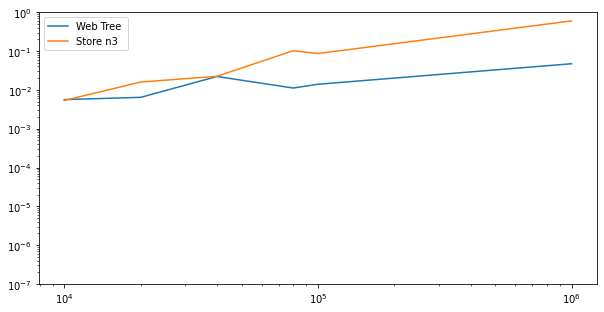

<PO>


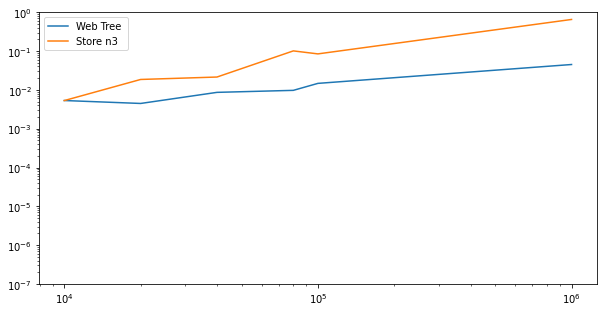

<SG>


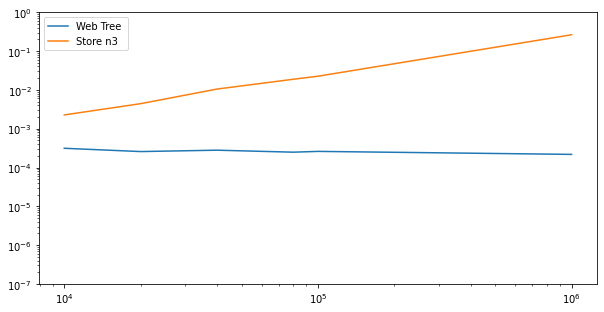

<S>


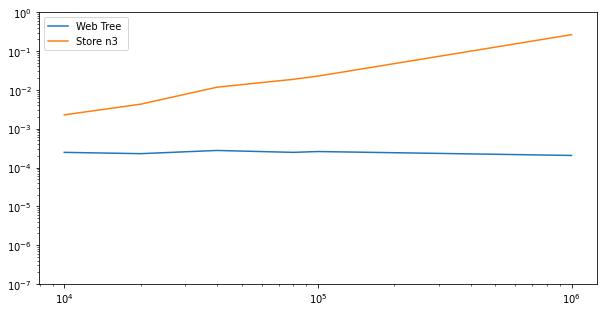

In [23]:
for q in queries:
    print(query_test(q))
    draw_plots([q], ["Web Tree", "Store n3"], ["Store"])